(nn/01-intro)=
# Introduction

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/01-intro.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:** https://github.com/ufal/npfl114/blob/master/lectures/lecture01.md

## Separating Hyperplane

Classification tasks using neural networks can be reduced to finding a separating hyperplanes after a sequence of transformations on the input data (i.e. projecting on the weight vectors to compute logits). There are generally as many separating hyperplanes as the number of classes. The distances to these hyperplanes are used to vote (e.g. using softmax) on the predicted class for that data point. For binary classification with softmax, the vectors subtract out resulting in one separating plane. This is demonstrated below.

### Generating data

In [1]:
import torch 
torch.manual_seed(3)

N = 400 # sample size
noise = lambda e: torch.randn(N, 2) * e
t = 2 * torch.pi * torch.rand(N, 1)
x1 = torch.cat([1.0 * torch.cos(t), 1.0 * torch.sin(t)], dim=1) + noise(0.1)
x0 = torch.cat([0.1 * torch.cos(t), 0.1 * torch.sin(t)], dim=1) + noise(0.05)

y1 = (torch.ones(N,) * 1).long()
y0 = (torch.ones(N,) * 0).long()

This generates data that is **not** linearly separable. Plotting:

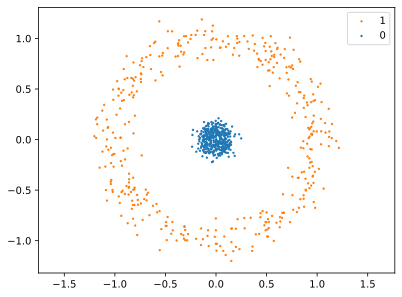

In [2]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

plt.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
plt.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
plt.legend()
plt.axis('equal');

### Model

In [3]:
import torch.nn as nn
from torchsummary import summary

model = lambda: nn.Sequential(
    nn.Linear(2, 3), 
    nn.ReLU(),
    nn.Linear(3, 2)
)

summary(model(), input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              ReLU-2                    [-1, 3]               0
            Linear-3                    [-1, 2]               8
Total params: 17
Trainable params: 17
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Data loaders

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

ds = TensorDataset(
    torch.cat([x0, x1], dim=0), 
    torch.cat([y0, y1], dim=0)
)

dl = DataLoader(ds, batch_size=3, shuffle=True)
x, y = next(iter(dl))
for i, _ in enumerate(x): 
    p = _.tolist()
    print(y[i].item(), f"[{p[0]:.3f}, {p[1]:.3f}]")

0 [-0.035, -0.078]
1 [0.439, -0.768]
0 [0.071, 0.142]


### Model training

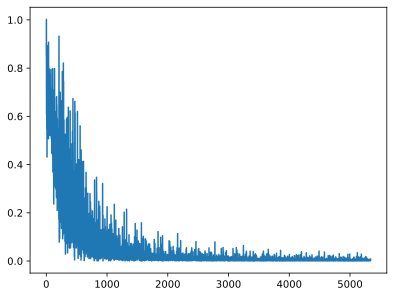

In [5]:
import torch.nn.functional as F

net = model()
loss_fn = lambda logits, y: F.cross_entropy(logits, y)
optim = torch.optim.SGD(net.parameters(), lr=0.1)

history = []
for epoch in range(20):
    for x, y in dl:
        logits = net(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        history.append(loss.item())
    
plt.plot(history);

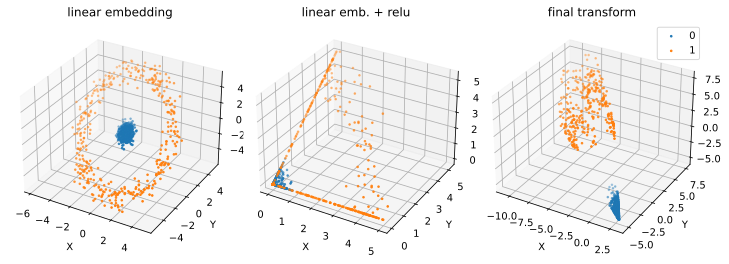

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# transformations
x0_3d = net[0](x0).detach().numpy()
x1_3d = net[0](x1).detach().numpy()
x0_3d_relu = net[1](net[0](x0)).detach().numpy()
x1_3d_relu = net[1](net[0](x1)).detach().numpy()
x0_final = net(x0).detach().numpy()
x1_final = net(x1).detach().numpy()

# plot
fig, ax = plt.subplots(ncols=3, figsize=(10, 16), subplot_kw={'projection': '3d'})
ax[0].scatter(x0_3d[:, 0], x0_3d[:, 1], x0_3d[:, 1], s=3, label=0, color="C0")
ax[0].scatter(x1_3d[:, 0], x1_3d[:, 1], x1_3d[:, 1], s=3, label=1, color="C1")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_zlabel('Z')
ax[0].set_title('linear embedding')

ax[1].scatter(x0_3d_relu[:, 0], x0_3d_relu[:, 1], x0_3d_relu[:, 1], s=3, label=0, color="C0")
ax[1].scatter(x1_3d_relu[:, 0], x1_3d_relu[:, 1], x1_3d_relu[:, 1], s=3, label=1, color="C1")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_zlabel('Z')
ax[1].set_title('linear emb. + relu')

ax[2].scatter(x0_final[:, 0], x0_final[:, 1], x0_final[:, 1], s=3, label=0, color="C0")
ax[2].scatter(x1_final[:, 0], x1_final[:, 1], x1_final[:, 1], s=3, label=1, color="C1")
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
ax[2].set_zlabel('Z')
ax[2].set_title('final transform')

fig.tight_layout()
plt.legend()
plt.show()

Seems linearly separable. Checking classification accuracy:

In [7]:
a = (torch.argmax(net(x0), dim=1) == y0).float().mean().item()
b = (torch.argmax(net(x1), dim=1) == y1).float().mean().item()
a, b

(1.0, 1.0)

## Universal Approximation Theorem (1989)

Here we approximate a one-dimensional curve using a neural network with ReLU activation.

In [8]:
x = torch.linspace(-2*torch.pi, 2*torch.pi, 1000)
y = torch.sin(x) + 0.3 * x

# Get (sorted) sample
B = torch.randint(0, 1000, size=(24,))
B = torch.sort(B)[0]
xs = x[B]
ys = y[B]

# ReLU approximation
z = torch.zeros(1000,)
for i in range(len(xs) - 1):
    if torch.isclose(xs[i + 1], xs[i]):
        m = torch.tensor(0.0)
    else:
        M = (ys[i+1] - ys[i]) / (xs[i+1] - xs[i])
        s, m = torch.sign(M), torch.abs(M)
    z += s * (torch.relu(m * (x - xs[i])) - torch.relu(m * (x - xs[i+1])))
z += ys[0]

Note this only works (consistent with the theorem) for target function with domain `[a, b]`.

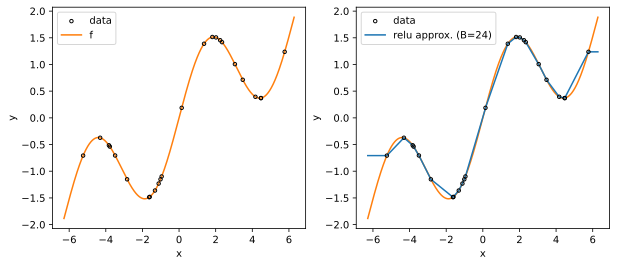

In [9]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(xs, ys, facecolor='none', s=12, edgecolor='k', zorder=3, label='data')
ax[0].plot(x, y, color="C1", label='f')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend();

ax[1].scatter(xs, ys, facecolor='none', s=12, edgecolor='k', zorder=4, label='data')
ax[1].plot(x, z, color="C0", label=f'relu approx. (B={len(B)})', zorder=3)
ax[1].plot(x, y, color="C1")
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend();

This works by constructing `___/‾‾‾` and `‾‾‾\___` functions similar to step functions but with slope in between adjacent points. The step functions increment each other starting with the constant function `ys[0]`. Note this correctly ends with a constant function `ys[-1]`.

## MNIST classification

**Lab:** https://github.com/ufal/npfl114/blob/master/tasks/mnist_layers_activations.md

### Data loaders

In [10]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x/255.)
])

mnist_train = datasets.MNIST(
    root='./data', 
    train=True,  
    download=True,
    transform=transform
)

mnist_valid = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True,
    transform=transform
)

dl_train = DataLoader(mnist_train, batch_size=50, shuffle=True, drop_last=True)
dl_valid = DataLoader(mnist_valid, batch_size=50)

Checking one batch:

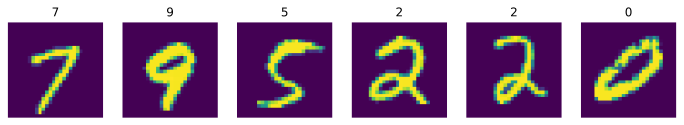

In [11]:
x, y = next(iter(dl_train))

fig, ax = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    ax[i].imshow(x[i].permute(1, 2, 0))
    ax[i].axis("off")
    ax[i].set_title(y[i].item())

### Model architecture

In [12]:
act_fn = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid()
}

def mnist_model(
        hidden_layers: int = 0,
        activation: str = None,
        hidden_size: int = 100,
        input_size: int = 784
    ):
    
    layers = [nn.Flatten()]

    m, n = input_size, hidden_size
    for i in range(hidden_layers):
        layers.append(nn.Linear(m, n))
        if activation:
            layers.append(act_fn[activation])
        m, n = hidden_size, hidden_size

    layers.append(nn.Linear(m, 10))
    model = nn.Sequential(*layers)

    return model


summary(mnist_model(3), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                   [-1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### Training

In [13]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

device = torch.device("mps")


@torch.no_grad()
def eval_model(model, dataloader):
    loss = 0
    correct = 0
    N = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)

        loss += F.cross_entropy(logits, y, reduction='sum').item()
        correct += sum(torch.argmax(logits, dim=1) == y).item()
        N += len(x)
    
    return {
        "loss": loss / N,
        "accs": correct / N
    }


def train_model(
        train_loader, 
        valid_loader,
        epochs=10, 
        hidden_layers=0, 
        activation=None, 
        input_size=784
    ):

    model = mnist_model(hidden_layers, activation, input_size=input_size).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    valid_loss = []
    valid_accs = []

    for epoch in tqdm(range(epochs)):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            train_loss.append(loss.item())

        e = eval_model(model, valid_loader)
        valid_loss.append(e["loss"])
        valid_accs.append(e["accs"])
            
    return {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_accs": valid_accs
    }

### Experiments

In [14]:
experiments = [
    {"hidden_layers":  0, "activation": None},
    {"hidden_layers":  1, "activation": None},
    {"hidden_layers":  1, "activation": "sigmoid"},
    {"hidden_layers": 10, "activation": "sigmoid"},
    {"hidden_layers":  1, "activation": "tanh"},
    {"hidden_layers":  1, "activation": "relu"},
    {"hidden_layers":  3, "activation": "relu"},
    {"hidden_layers": 10, "activation": "relu"},
]

results = {}

for params in experiments:
    results[tuple(params.values())] = train_model(dl_train, dl_valid, **params)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Plotting the results:

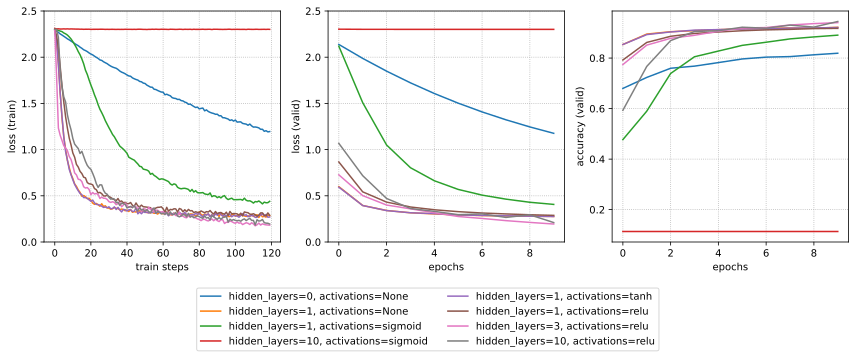

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (params, hist) in enumerate(results.items()):
    ax[0].plot(torch.tensor(hist['train_loss']).view(-1, 100).mean(dim=1), color=f"C{i}")
    ax[1].plot(hist['valid_loss'], color=f"C{i}")
    ax[2].plot(hist['valid_accs'], label=f"hidden_layers={params[0]}, activations={params[1]}", color=f"C{i}")

ax[0].set_xlabel("train steps")
ax[1].set_xlabel("epochs")
ax[2].set_xlabel("epochs")
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
ax[2].grid(linestyle='dotted')
ax[0].set_ylabel("loss (train)")
ax[1].set_ylabel("loss (valid)")
ax[2].set_ylabel("accuracy (valid)")
ax[1].set_ylim(0, 2.5)
ax[0].set_ylim(0, 2.5)

fig.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=2)
fig.tight_layout();

**Results.** 10 layers with sigmoid is remarkably bad. This is because of repeated squashing. ReLU networks perform well benefiting from added depth (although not too much). Tanh with a derivative of 1 at zero improves the performance of sigmoid.

## Principal Component Analysis (PCA)

**Lab:** https://github.com/ufal/npfl114/blob/master/tasks/pca_first.md

PCA looks for a hyperplane (e.g. with dimension $n \ll d$) such that the projection of the $d$-dimensional data on the hyperplane has iteratively maximal variance starting from the first orthonormal vector. In other words, the data is projected on a hyperplane such that the projected data points have maximal separability along each dimension.


![pca-ds-handbook](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.09-PCA-rotation.png)

**Figure.** PCA on a blob of data (left). Components in PCA space also shown (right). [Source]( https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html )

### PCs = eigenvectors

Let $\boldsymbol{\mathsf{S}} \in \mathbb{R}^{d \times d}$ be the sample covariance of the data. PCA is an optimization problem $\max_{\boldsymbol{\mathsf{u}}_1} {{\boldsymbol{\mathsf{u}}_1}^{\top}}\,\boldsymbol{\mathsf{S}}\,{\boldsymbol{\mathsf{u}}_1}$ with the constraint ${{\boldsymbol{\mathsf{u}}_1}^{\top}}{\boldsymbol{\mathsf{u}}_1} = 1.$ The unit vector ${\boldsymbol{\mathsf{u}}_1}$ is called the first **principal component** (PC). This can be solved using Lagrange multiplers. It turns out that the first principal components is the eigenvecter of $\boldsymbol{\mathsf{S}}$ corresponding to the largest eigenvalue. The eigenvalue also turns out to be the variance along that dimension.

Recall that $\boldsymbol{\mathsf{S}}$ is symmetric positive semidefnite so that it has $d$ nonnegative eigenvalues with corresponding $d$ orthonormal eigenvectors. In particular, we can order the eigenvalues as $\lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_d.$ The next principal components can be solved using the same Lagrange multipliers method with added constraints due to its orthogonality with earlier principal components. Nevertheless, we still get the same results that the principal component is the eigenvector ${\boldsymbol{\mathsf{u}}_j}$ corresponding to the next largest eigenvalue $\lambda_j.$

**Remark.** See [this video](https://www.youtube.com/watch?v=L-pQtGm3VS8) on PCA and [this video](https://www.youtube.com/watch?v=5A39Ht9Wcu0) on understanding Lagrange multipliers.

### First principal component

Here we solve the first PC of MNIST train using [power iteration](https://en.wikipedia.org/wiki/Power_iteration):

In [16]:
def sample_covariance(size):
    """Compute covariance matrix of subset of data."""
    B = torch.randint(0, len(mnist_train), size=(size,))
    data = [mnist_train[b][0].view(-1) for b in B]

    X = torch.stack(data, dim=0)
    m = X.mean(dim=0)
    cov = (X - m).T @ (X - m) / X.shape[0]
    
    return {
        'cov': cov,
        'mean': m
    }

Computing the sample covariance of 30,000 random data points:

In [17]:
examples = len(mnist_train)
sample = sample_covariance(examples)
cov = sample['cov']
total_variance = cov.diag().sum()

Using power iteration we can approximate $\lambda_1 {\boldsymbol{\mathsf{u}}_1}$:

In [18]:
iterations = 1024
v = torch.ones(784)
for i in range(iterations):
    v = v @ cov
    s = torch.norm(v)
    v = v / s

It follows that the norm of this vector is the explained variance by the first PC:

In [19]:
print(f"--iterations={iterations} --examples={examples}")
print(f"Total variance: {total_variance:.5f}")
print(f"Explained variance: {(s / total_variance).item() * 100:.2f}%")

--iterations=1024 --examples=60000
Total variance: 0.00081
Explained variance: 9.67%


See below for an explanation of **explained variance**.

### Explained variance

Recall that the trace of a matrix is equal to the sum of its eigenvalues. For the covariance matrix, its trace is the sum of individual variances of each data point, so that the individual variances along the principal dimensions, i.e. $\sum_{j=1}^d \lambda_j$, also sum to this value. 
This is the **total variance**.
Below we will compute $\lambda_j / S$ where $S = \text{trace}(\boldsymbol{\mathsf{S}})$ to measure the amount of variance "explained" by one PD. 

Computing the sum of all eigenvalues:

In [20]:
print(f"Total variance:    {total_variance:.5f}")
print(f"Total eigenvalues: {torch.linalg.eigvals(cov).sum().real.item():.5f}")

Total variance:    0.00081
Total eigenvalues: 0.00081


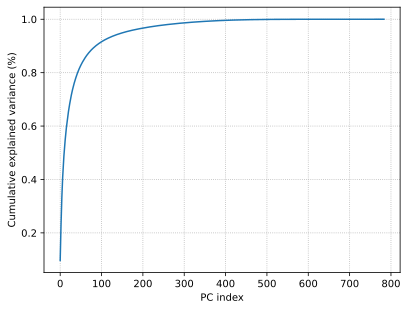

In [21]:
cs = torch.cumsum(torch.linalg.eigvals(cov).real, dim=0)
plt.plot(cs / total_variance)
plt.grid(linestyle='dotted')
plt.ylabel("Cumulative explained variance (%)")
plt.xlabel("PC index");

**Remark.** This graph shows that we can preserve a significant percentage of the total variance by using only a small number of dimensions (e.g. ~100). See next section.

### PC decomposition

Note that the principal components are orthonormal vectors which can form a **basis** of the data space. The components along each dimension can be obtained using projection. The following reconstructs an instance using this technique of PCs as basis. The approximation should get better as we use more basis vectors (refer to the graph above):

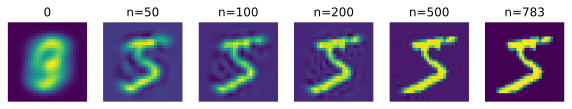

In [22]:
# Sample data point
x, y = mnist_train[0]
x = x.view(-1)

eigvecs = torch.linalg.eig(cov).eigenvectors.real.T # 👈 >_<, (try without .T)
m = torch.clone(sample['mean'])

checkpoints = [50, 100, 200, 500, 783]
fig, ax = plt.subplots(1, len(checkpoints) + 1, figsize=(10, 3))
x_pca = m
ax[0].set_title(0)
ax[0].imshow(x_pca.view(28, 28))
ax[0].axis('off')

j = 1
for i in range(784):
    u = eigvecs[i]
    x_pca += ((x - m) @ u) * u
    if i + 1 in checkpoints:
        ax[j].set_title(f"n={i+1}")
        ax[j].imshow(x_pca.view(28, 28))
        ax[j].axis('off')
        j += 1

Principal components:

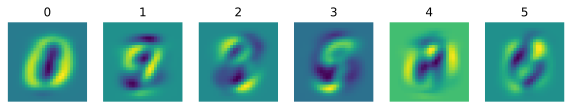

In [23]:
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

for i in range(6):
    u = eigvecs[i]
    ax[i].set_title(i)
    ax[i].imshow(u.view(28, 28))
    ax[i].axis('off')

### Dimensionality reduction

Here we project MNIST onto a 200-dimensional hyperplane (i.e. obtained using the first 200 principal components). This section also presents PCA in the framework of machine learning by using the training set to compute the PCs and then applying them on the validation dataset:

In [24]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

        # learned stuff
        self.cov = None
        self.mean = None
        self.components = None
        self.variances = None


    def fit(self, X):
        
        # compute sample covariance
        m = X.mean(dim=0)
        cov = (X - m).T @ (X - m) / X.shape[0]
        self.cov = cov
        self.mean = m

        # compute principal components
        eigvals, eigvecs = torch.linalg.eig(cov)
        self.components = eigvecs.real.T    # (!)
        self.variances  = eigvals.real
        
        n = self.n_components
        U = self.components[:n]
        explained_variance = sum(self.variances[:n]) / sum(self.variances)
        mae = (X - self.transform(X) @ U).abs().mean()
        print(f"Explained variance: {explained_variance * 100:.2f}%")
        print(f"MAE train: {mae: .2e}")


    def transform(self, x):
        if len(x.shape) != 2:
            raise Exception("Input must have dimension 2.")
        
        U = self.components[:self.n_components]
        m = self.mean
        return (x - m) @ U.T


    def explained_variance(self):
        if self.components is not None:
            cs = torch.cumsum(self.variances, dim=0)
            total_variance = sum(self.variances)
            return (cs / total_variance).tolist()
        else:
            raise Exception("PCA object not trained.")

**Remark.** Note that the eigenvector matrix has columns as eigenvectors. Hence the `.T` to get rows.

In [25]:
pca = PCA(n_components=200)
data = [mnist_train[b][0].view(-1) for b in range(len(mnist_train))]
X = torch.stack(data, dim=0)
pca.fit(X)

Explained variance: 96.64%
MAE train:  5.29e-04


Custom transform using the PCA object:

In [26]:
X_train, Y_train = zip(*[mnist_train[b] for b in range(len(mnist_train))])
X_valid, Y_valid = zip(*[mnist_valid[b] for b in range(len(mnist_valid))])

X_train = torch.stack(X_train, dim=0).view(-1, 784)
X_valid = torch.stack(X_valid, dim=0).view(-1, 784)

X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)

ds_train_pca = TensorDataset(X_train_pca, torch.tensor(Y_train))
ds_valid_pca = TensorDataset(X_valid_pca, torch.tensor(Y_valid))
dl_train_pca = DataLoader(ds_train_pca, batch_size=50, shuffle=True, drop_last=True)
dl_valid_pca = DataLoader(ds_valid_pca, batch_size=50)

Reconstructing MNIST instances using 200 components:

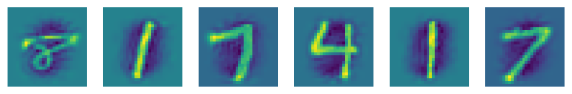

In [27]:
x_pca, y = next(iter(dl_train_pca))
U = pca.components[:200]
x_recon = x_pca @ U

fig, ax = plt.subplots(1, 6, figsize=(10, 4))
for i in range(6):
    ax[i].imshow(x_recon[i].view(28, 28))
    ax[i].axis("off");

Looks good. Model trained on PCA data performed well:

In [28]:
params = {"hidden_layers": 1, "activation": "sigmoid", "input_size": 200}
result_pca = train_model(dl_train_pca, dl_valid_pca, **params)

  0%|          | 0/10 [00:00<?, ?it/s]

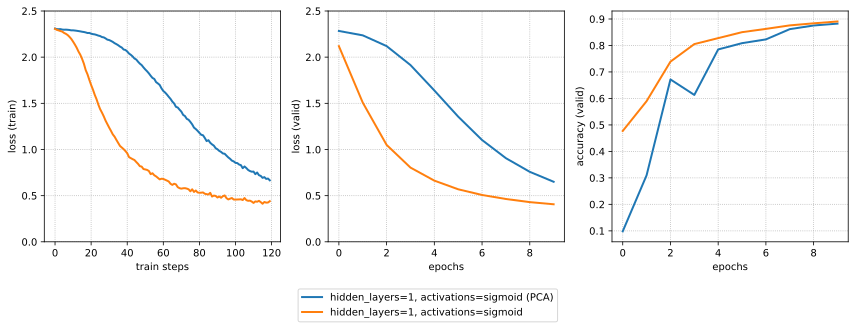

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(torch.tensor(result_pca['train_loss']).view(-1, 100).mean(dim=1), linewidth=2)
ax[1].plot(result_pca['valid_loss'], linewidth=2)
ax[2].plot(result_pca['valid_accs'], label=f"hidden_layers={params['hidden_layers']}, activations={params['activation']} (PCA)", linewidth=2)

ax[0].plot(torch.tensor(results[(1, 'sigmoid')]['train_loss']).view(-1, 100).mean(dim=1), linewidth=2)
ax[1].plot(results[(1, 'sigmoid')]['valid_loss'], linewidth=2)
ax[2].plot(results[(1, 'sigmoid')]['valid_accs'], label=f"hidden_layers=1, activations=sigmoid", linewidth=2)

ax[0].set_xlabel("train steps")
ax[1].set_xlabel("epochs")
ax[2].set_xlabel("epochs")
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
ax[2].grid(linestyle='dotted')
ax[0].set_ylabel("loss (train)")
ax[1].set_ylabel("loss (valid)")
ax[2].set_ylabel("accuracy (valid)")
ax[1].set_ylim(0, 2.5)
ax[0].set_ylim(0, 2.5)

fig.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=1)
fig.tight_layout();

---

In [30]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("Last updated:", dt_string)

Last updated: 22/05/2023 06:10:32
